# Redes Neurais Artificiais – Projeto Prático 2.1
## Aprendizado Supervisionado no Neurônio Perceptron
Neste projeto prático, o objetivo é implementar o algoritmo de treinamento mediante Aprendizado Supervisionado do neurônio Perceptron de Rosenblatt aplicado em problemas de classificação.

---

### Equipe (Identificador: 3):

*   Adriana Raffaella Dos Santos Fonseca
*   Ana Flavia de Castro Segadilha da Silva
*   Guilherme Gonçalves Moraes
*   Yago De Oliveira Feitoza



## Bibliotecas

In [ ]:
#Importação das bibliotecas
import gdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import math
from prettytable import PrettyTable
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## Leitura de Dados

In [ ]:
# Baixar o arquivo do Google Drive
gdown.download('https://drive.google.com/uc?export=download&id=18xVywKIw4WCCDXXAf-G-DflLfA5EQeeM', 'dataAll.txt', quiet=False)

# Carregar os dados binários diretamente para um numpy.ndarray
ndarray = np.fromfile('dataAll.txt', dtype=np.float64)

# A partir dos dados binários, reorganizar para a forma correta (m, 1, 3)
ndarray = ndarray.reshape(-1, 1, 3)

#Retirando a dimensão do meio
ndarray_2d = ndarray.reshape(-1, 3)

#DataFrame dos dados
data = pd.DataFrame(ndarray_2d, columns=['Dado 1', 'Dado 2', 'Y desejado'])

# Exibir as 5 primeiras linhas dos dados carregados
print(f'\n\n{data.head()}')

#Separando as variáveis X(input) e y_d (y desejado)
X = data[['Dado 1', 'Dado 2']].values #Exemplos da primeira e segunda coluna
y_d = data[['Y desejado']].values #Última coluna

Downloading...
From: https://drive.google.com/uc?export=download&id=18xVywKIw4WCCDXXAf-G-DflLfA5EQeeM
To: /content/dataAll.txt
100%|██████████| 24.0k/24.0k [00:00<00:00, 19.3MB/s]



     Dado 1    Dado 2  Y desejado
0 -363.7884  244.1423         0.0
1  328.7572 -256.7658         1.0
2 -164.9827  613.2164         0.0
3  536.5905  764.9575         0.0
4  314.2297  343.8375         0.0


## Parte I – Resolvendo um Problema Linearmente Separável

###Implementação do Neurônio Perceptron

In [ ]:
class Perceptron:

    def __init__(self, n_inputs, taxa_aprendizado=0.1, max_epocas=1000, intervalo_pesos=(-0.5, 0.5)):
        self.pesos = np.random.uniform(intervalo_pesos[0], intervalo_pesos[1], size=n_inputs + 1)
        self.pesos_iniciais = f'[{self.pesos[0]:.2f}, {self.pesos[1]:.2f}, {self.pesos[2]:.2f}]'
        self.taxa_aprendizado = taxa_aprendizado
        self.max_epocas = max_epocas
        self.epocas = 0
        self.ajuste_pesos = 0
        self.intervalo_pesos_print = f'{intervalo_pesos[0]}, {intervalo_pesos[1]}' # Adicionada para a Parte 2


    #Função degrau com θ=0
    def funcao_ativacao(self, x):
        return 1 if x >= 0 else 0

    def previsao(self, x):
        xi_vies = np.insert(x, 0, 1)
        return self.funcao_ativacao(np.dot(xi_vies, self.pesos))

    def train(self, X, y, intervalo_pesos=(-0.5, 0.5)):

        while self.epocas < self.max_epocas:
            erro_flag = False
            for xi, y_d in zip(X, y):
                y_p = self.previsao(xi)
                error = y_d - y_p
                xi_vies = np.insert(xi, 0, 1)
                #Aplicação da Regra Delta
                if error != 0:
                    self.pesos += self.taxa_aprendizado * error * xi_vies
                    self.ajuste_pesos += 1
                    erro_flag = True
            self.epocas += 1
            if not erro_flag:
                break

    # Função adicionada para a Parte 2
    def calcular_media(self, ajustes_peso):
        return sum(ajustes_peso) / len(ajustes_peso)

    # Função adicionada para a Parte 2
    def calcular_minimo(self, todas_epocas):
        return min(todas_epocas)

    def grafico(self, X, y):

        # Plotando os dados e a reta de separação
        plt.figure(figsize=(6, 6))
        for label in data["Y desejado"].unique():
            subset = data[data["Y desejado"] == label]
            plt.scatter(subset["Dado 1"], subset["Dado 2"], label=f"Classe {int(label)}", alpha=0.7)

        # Ajuste para a linha de decisão
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x_vals = np.array([x_min, x_max]) #valores de x
        y_vals = (self.pesos[0] / self.pesos[2]) - (self.pesos[1] / self.pesos[2]) * x_vals #valores de y


        # Linha de decisão (ajustada para destacar)
        plt.plot(x_vals, y_vals, color='black', label='Linha de decisão', linewidth=2)

        # Estilizando o gráfico
        plt.title("Resultados")
        plt.xlabel("Dado 1")
        plt.ylabel("Dado 2")
        plt.legend()
        plt.grid(False)
        plt.show()

###Resultados do Treinamento

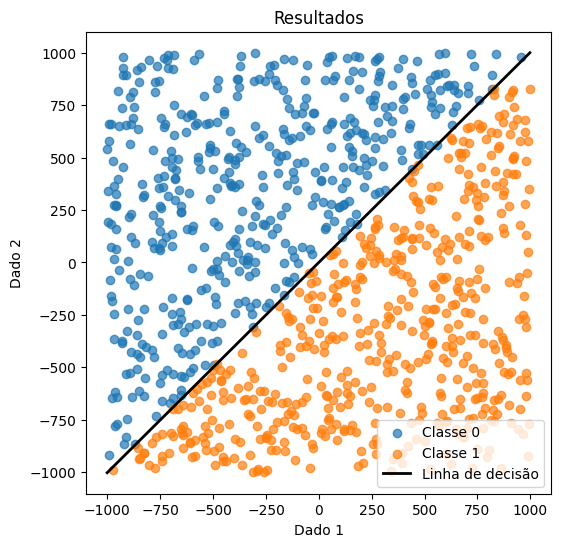

Pesos iniciais : [-0.37, -0.29, -0.45]
Quantidade de ajustes no vetor de pesos: 34
Pesos finais após treinamento: [0.23, 268.85, -268.35]
Quantidade de épocas: 3



In [ ]:
perceptron = Perceptron(n_inputs=X.shape[1])

perceptron.train(X, y_d)
perceptron.grafico(X, y_d)

print(f"Pesos iniciais : {perceptron.pesos_iniciais}")
print(f"Quantidade de ajustes no vetor de pesos: {perceptron.ajuste_pesos}")
print(f"Pesos finais após treinamento: [{perceptron.pesos[0]:.2f}, {perceptron.pesos[1]:.2f}, {perceptron.pesos[2]:.2f}]")
print(f"Quantidade de épocas: {perceptron.epocas}\n")

## Parte II – Experimentação

###Leitura do arquivo data3.txt

In [ ]:
# Baixar o arquivo do Google Drive
gdown.download('https://drive.google.com/uc?export=download&id=1RoXGITcMlWDFydO8Y16Vw1MgPvpl6q75', 'data3.txt', quiet=False)

# Carregar os dados binários diretamente para um numpy.ndarray
ndarray_3 = np.fromfile('data3.txt', dtype=np.float64)

# A partir dos dados binários, reorganizar para a forma correta (m, 1, 3)
ndarray_3 = ndarray_3.reshape(-1, 1, 3)

#Retirando a dimensão do meio
ndarray_32d = ndarray_3.reshape(-1, 3)

#DataFrame dos dados
data3 = pd.DataFrame(ndarray_32d, columns=['Dado 1', 'Dado 2', 'Y desejado'])

# Exibir as 5 primeiras linhas dos dados carregados
print(f'\n\n{data3.head()}')

#Separando as variáveis X(input) e y_d (y desejado)
X = data3[['Dado 1', 'Dado 2']].values #Exemplos da primeira e segunda coluna
y_d = data3[['Y desejado']].values #Última coluna

Downloading...
From: https://drive.google.com/uc?export=download&id=1RoXGITcMlWDFydO8Y16Vw1MgPvpl6q75
To: /content/data3.txt
100%|██████████| 14.4k/14.4k [00:00<00:00, 20.4MB/s]



     Dado 1    Dado 2  Y desejado
0  0.061628 -0.124257         0.0
1 -0.125767 -0.203857         0.0
2  0.036252 -0.126108         0.0
3 -0.003661  0.023619         0.0
4 -0.154962  0.145064         0.0


### Listas de *η* e *I*

In [ ]:
taxas_aprendizado = [0.4, 0.1, 0.01] # Possíveis valores para a Taxa de Apendizado
intervalos_pesos = [(-0.5, 0.5), (-100, 100)] # Possíveis valores para intervalo de peso

### Inicialização da Tabela

In [ ]:
table = PrettyTable()
table.field_names = ["Taxa de Aprendizado", "Intervalo de Pesos", "Quantidade de Ajustes", "Menor número de épocas para convergência"]

### Testes e resultados

In [ ]:
ajustes_peso = [] # inicializando a lista vazia para cálculo de média
todas_epocas = [] # inicializando a lista vazia para achar a mínima quantidade de épocas para convergência


for taxa_aprendizados in taxas_aprendizado:
    for intervalo_peso in intervalos_pesos:

        repeticao = 0
        while repeticao <= 10:

            perceptron = Perceptron(n_inputs=X.shape[1], taxa_aprendizado=taxa_aprendizados, intervalo_pesos=intervalo_peso)
            perceptron.train(X, y_d)

            ajustes_peso.append(perceptron.ajuste_pesos)
            todas_epocas.append(perceptron.epocas)

            desvio_padrao = float(np.std(ajustes_peso))

            quantidade_ajuste = f'{perceptron.calcular_media(ajustes_peso):.2f} ± {desvio_padrao:.2f}'

            repeticao += 1

        table.add_row([f'η = {perceptron.taxa_aprendizado}', f'({perceptron.intervalo_pesos_print})', quantidade_ajuste , perceptron.calcular_minimo(todas_epocas)])

print(table)


+---------------------+--------------------+-----------------------+------------------------------------------+
| Taxa de Aprendizado | Intervalo de Pesos | Quantidade de Ajustes | Menor número de épocas para convergência |
+---------------------+--------------------+-----------------------+------------------------------------------+
|       η = 0.4       |    (-0.5, 0.5)     |      7.18 ± 2.85      |                    3                     |
|       η = 0.4       |    (-100, 100)     |     95.45 ± 118.74    |                    3                     |
|       η = 0.1       |    (-0.5, 0.5)     |     67.09 ± 104.94    |                    3                     |
|       η = 0.1       |    (-100, 100)     |    346.48 ± 618.00    |                    3                     |
|       η = 0.01      |    (-0.5, 0.5)     |    287.69 ± 565.34    |                    1                     |
|       η = 0.01      |    (-100, 100)     |   2473.83 ± 5729.83   |                    1               

# Parte III - Validação Holdout em Problema Não-Linearmente Separável

# Leitura do arquivo dataHoldout.txt

In [ ]:
# Baixar o arquivo do Google Drive
gdown.download('https://drive.google.com/uc?export=download&id=1YsbXP2Tx3d9eHxJsqAdjfHksEZonqekf', 'dataHoldout.txt', quiet=False)

# Carregar os dados binários diretamente para um numpy.ndarray
ndarray_holdout = np.fromfile('dataHoldout.txt', dtype=np.float64)

# A partir dos dados binários, reorganizar para a forma correta (m, 1, 3)
ndarray_holdout = ndarray_holdout.reshape(-1, 1, 3)

#Retirando a dimensão do meio
ndarray_holdout_2d = ndarray_holdout.reshape(-1, 3)

#DataFrame dos dados
data_holdout = pd.DataFrame(ndarray_holdout_2d, columns=['Dado 1', 'Dado 2', 'Y desejado'])

# Exibir as 5 primeiras linhas dos dados carregados
print(f'\n\n{data_holdout.head()}')

#Separando as variáveis X(input) e y_d (y desejado)
X = data_holdout[['Dado 1', 'Dado 2']].values #Exemplos da primeira e segunda coluna
y_d = data_holdout[['Y desejado']].values #Última coluna

Downloading...
From: https://drive.google.com/uc?export=download&id=1YsbXP2Tx3d9eHxJsqAdjfHksEZonqekf
To: /content/dataHoldout.txt
100%|██████████| 19.2k/19.2k [00:00<00:00, 21.5MB/s]



     Dado 1    Dado 2  Y desejado
0 -0.293230 -0.090654         1.0
1  0.079888  0.211013         1.0
2 -0.078256 -0.080835         1.0
3 -0.468334 -0.106207         1.0
4  0.463041  0.094055         1.0


# Visualização dos Dados


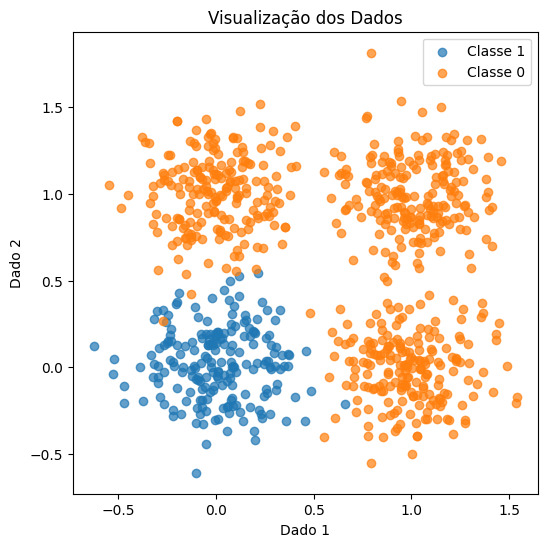

In [ ]:
plt.figure(figsize=(6, 6))
for label in data_holdout["Y desejado"].unique():
    subset = data_holdout[data_holdout["Y desejado"] == label]
    plt.scatter(subset["Dado 1"], subset["Dado 2"], label=f"Classe {int(label)}", alpha=0.7)

plt.title("Visualização dos Dados")
plt.xlabel("Dado 1")
plt.ylabel("Dado 2")
plt.legend()
plt.grid(False)
plt.show()

# Divisão Holdout

In [ ]:
X = data_holdout[["Dado 1", "Dado 2"]].values
y = data_holdout["Y desejado"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3, stratify=y)

# Chamada do Neurônio Perceptron

In [ ]:
np.random.seed(3)
perceptron = Perceptron(n_inputs=X.shape[1], taxa_aprendizado=0.01)
perceptron.train(X_train, y_train)

# Avaliação e Métricas

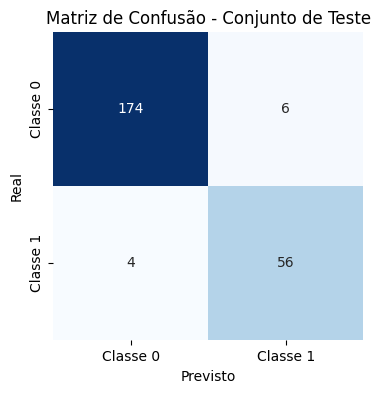

Acurácia:   0.9583
Precisão:   0.9032
Revocação:  0.9333
F1-Score:   0.9180


In [ ]:
# Previsões
y_pred_test = np.array([perceptron.previsao(x) for x in X_test])

# Cálculo das métricas
conf_matrix = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Exibir matriz de confusão
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Conjunto de Teste")
plt.show()

# Imprimir métricas
print(f"Acurácia:   {accuracy:.4f}")
print(f"Precisão:   {precision:.4f}")
print(f"Revocação:  {recall:.4f}")
print(f"F1-Score:   {f1:.4f}")

# Gráficos com fronteira de decisão

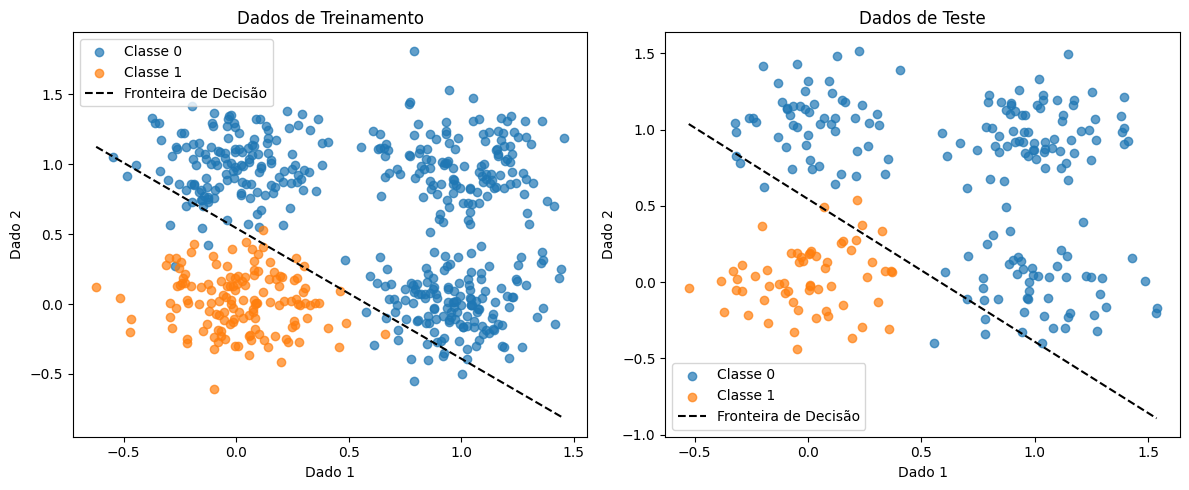

In [ ]:
def plot_decision_boundaries_side_by_side(X_train, y_train, X_test, y_test, perceptron):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    datasets = [(X_train, y_train, "Dados de Treinamento"), (X_test, y_test, "Dados de Teste")]

    for ax, (X, y, title) in zip(axes, datasets):
        for label in np.unique(y):
            subset = X[y == label]
            ax.scatter(subset[:, 0], subset[:, 1], label=f"Classe {int(label)}", alpha=0.7)

        x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
        if perceptron.pesos[2] != 0:
            y_vals = -(perceptron.pesos[0] + perceptron.pesos[1]*x_vals) / perceptron.pesos[2]
            ax.plot(x_vals, y_vals, 'k--', label="Fronteira de Decisão")

        ax.set_title(title)
        ax.set_xlabel("Dado 1")
        ax.set_ylabel("Dado 2")
        ax.grid(False)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Chamar a função
plot_decision_boundaries_side_by_side(X_train, y_train, X_test, y_test, perceptron)

### Análise da Qualidade da Solução com Base nas Métricas do Conjunto de Testes

A avaliação do modelo Perceptron sobre o conjunto de testes forneceu os seguintes resultados:

- **Acurácia:** 0.9583  
- **Precisão:** 0.9032  
- **Revocação (Recall):** 0.9333  
- **F1-Score:** 0.9180  

---

#### Discussão Crítica

Os resultados obtidos demonstram que o Perceptron teve um desempenho bastante satisfatório na tarefa de classificação. A acurácia de aproximadamente 95,8% indica uma taxa global de acertos elevada, enquanto as métricas de precisão e revocação mostram que o modelo possui um bom equilíbrio entre a capacidade de evitar falsos positivos e identificar corretamente os exemplos positivos.

A **precisão** de 90,32% sugere que, entre todas as previsões positivas feitas pelo modelo, a maioria foi de fato correta. Já a **revocação** de 93,33% indica que o Perceptron conseguiu identificar a maior parte das amostras pertencentes à classe positiva. O **F1-Score** de 91,80%, por sua vez, confirma que o modelo mantém um bom equilíbrio entre essas duas medidas, sendo especialmente útil em cenários com distribuição de classes relativamente equilibrada.

---

#### Considerações Importantes

Apesar dos bons resultados, é importante observar que o modelo ainda cometeu alguns erros de classificação: 6 instâncias da classe 0 foram incorretamente classificadas como classe 1, e 4 da classe 1 foram classificadas como classe 0. Isso evidencia a limitação do Perceptron ao lidar com regiões que não são perfeitamente separáveis por uma fronteira linear.

Recomenda-se, portanto, como continuidade do trabalho:

- Avaliar o modelo com **validação cruzada (k-fold)**;
- Comparar com classificadores não lineares, como SVM com kernel, redes neurais multicamadas, ou árvore de decisão;
- Verificar a performance com diferentes taxas de aprendizado e épocas de treinamento.

---

#### Conclusão

> O Perceptron apresentou uma performance sólida no conjunto de testes, com métricas que evidenciam boa generalização. No entanto, os erros observados sugerem que, embora eficaz, o modelo pode se beneficiar de abordagens mais robustas para problemas não linearmente separáveis.


